In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

In [2]:
df = pd.read_csv("../../data/sir-am-7d.csv")
df[:5]

,I
0,1185.428571
1,1309.714286
2,1454.857143
3,1627.428571
4,1838.428571


In [3]:
I_data = df["I"].to_numpy()
I_data[:5]

array([1185.42857143, 1309.71428571, 1454.85714286, 1627.42857143,
       1838.42857143])

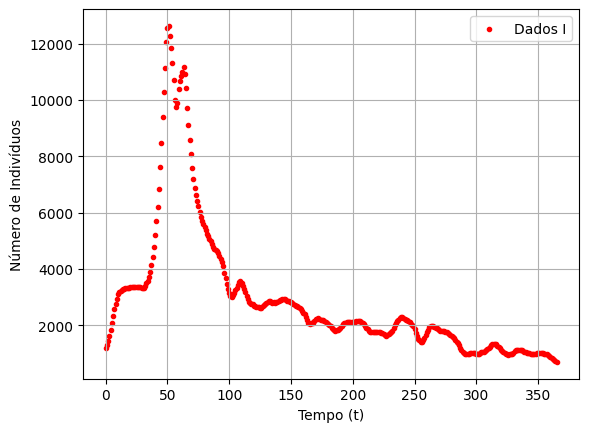

In [4]:
t_0, t_f = 0, len(I_data) - 1
data_t = np.linspace(t_0, t_f, len(I_data))
plotting.plot_incidence_data(data_t, I_data, "incidence-data-am-2023")

In [5]:
N = 8116132 # population size

In [6]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, 1/7, 
    activation="tanh",
    n_hidden_layers=3,
    hidden_layer_size=80, 
    scaling="min/max",
    estimate_beta=True,
    beta_estimation_window=5,
    adaptative_wdata=False,
    early_stopping=False)

Compiling model...
'compile' took 0.006034 s



In [ ]:
model.S0, model.I0, model.beta0 

In [7]:
model.train()

(<deepxde.model.LossHistory at 0x7ffac27ed090>,
 <deepxde.model.TrainState at 0x7ffab90eb090>)

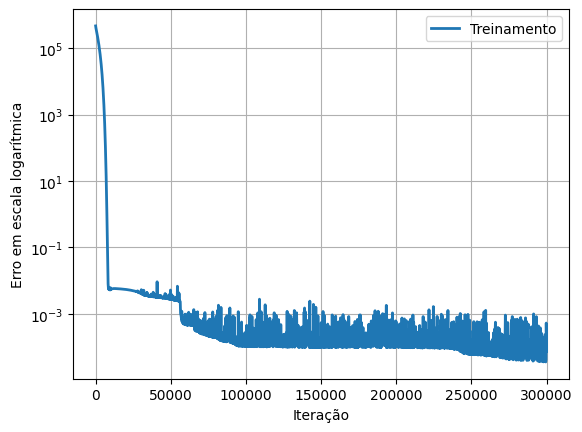

In [8]:
plotting.plot_losshistory(model.losshistory, "loss-am-2023")

In [9]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

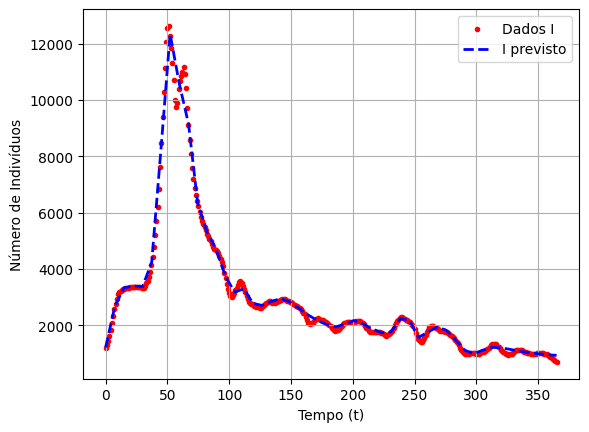

In [10]:
plotting.plot_incidence_results(I_data, data_t, pred[:,1:2], test_t, "incidence-results-am-2023")

ValueError: not enough values to unpack (expected 3, got 1)

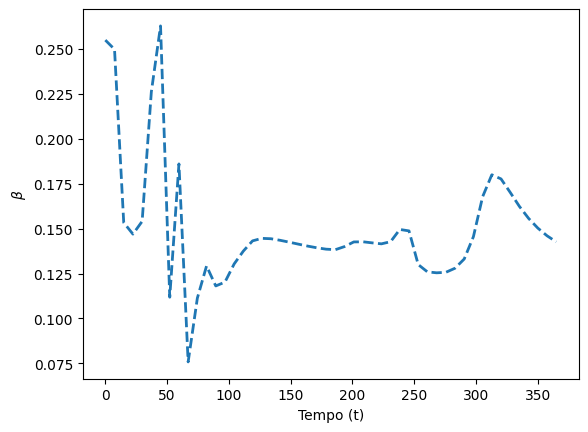

In [19]:
plotting.plot_beta_prediction(pred[:,2], test_t, "beta-am-2023")

In [13]:
pred_eval = model.predict(data_t)
eval_predictions(I_data.reshape(-1,1), pred_eval[:,1].reshape(-1,1), ["I"])

,compartiment,RMSE,L2,L-infinity
0,I,72.139477,0.018919,271.264822


In [14]:
model.formated_total_training_time

'01:08:27'

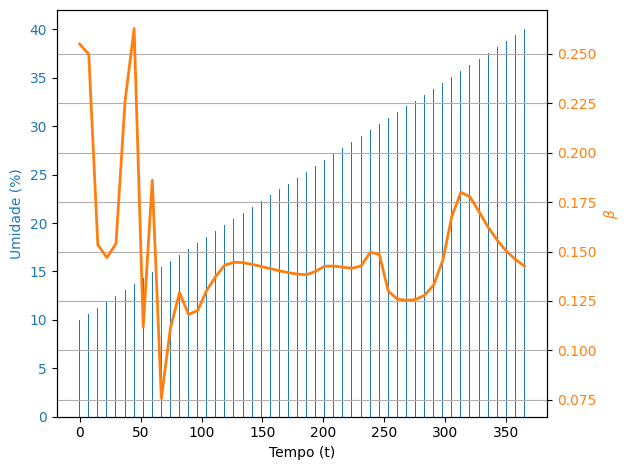

In [15]:
humidity = np.linspace(10, 40, 50)

correlation_t = np.linspace(t_0, t_f, len(humidity))
pred_beta_correlation = model.predict(correlation_t)[:,2]

plotting.plot_correlation(
    pred_beta_correlation, 
    humidity, 
    correlation_t, 
    "Umidade (%)",
    "beta-humidity-correlation"
)

In [16]:
pearson_test = pearsonr(pred_beta_correlation, humidity)
pearson_test.statistic, pearson_test.pvalue

(np.float64(-0.20943709414386694), np.float64(0.14436400713594633))

In [17]:
spearman_test = spearmanr(pred_beta_correlation, humidity)
spearman_test.statistic, spearman_test.pvalue

(np.float64(0.03414165666266506), np.float64(0.8139135104843961))